In [3]:
import pandas as pd
import requests

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('APIData2000-FB.csv')

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df = df[df['Ruling_Slug']!= 'no-flip']
df = df[df['Ruling_Slug']!= 'full-flop'] 
df = df[df['Ruling_Slug']!= 'half-flip']
df = df[df['Ruling_Slug']!= 'barely-true']
df.Ruling_Slug.unique()

array(['false', 'mostly-true', 'pants-fire', 'half-true', 'true'],
      dtype=object)

In [7]:
df.loc[df['Ruling_Slug'] == 'half-true', 'Ruling_Slug'] = 'true'
df.loc[df['Ruling_Slug'] == 'mostly-true', 'Ruling_Slug'] = 'true'
df.loc[df['Ruling_Slug'] == 'mostly-false', 'Ruling_Slug'] = 'false'
df.loc[df['Ruling_Slug'] == 'pants-fire', 'Ruling_Slug'] = 'false'
#df.loc[df['Ruling_Slug'] == 'barely-true', 'Ruling_Slug'] = 'false'
df.Ruling_Slug.unique()

array(['false', 'true'], dtype=object)

In [8]:
labels = df.Ruling_Slug
labels.unique()

array(['false', 'true'], dtype=object)

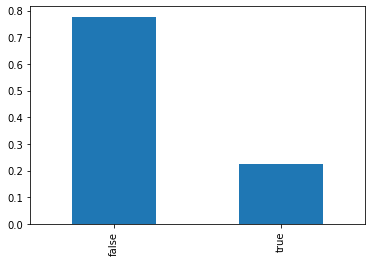

In [9]:
import numpy as np
(df['Ruling_Slug'].value_counts()/np.float(len(df))).plot.bar()

In [10]:
# balancing the dataset 
from sklearn.utils import resample
df_majority = df[df['Ruling_Slug']=='false']
df_minority = df[df['Ruling_Slug']=='true']
df_minority_oversampled = resample(df_minority, replace=True, n_samples=1095, random_state=0)
df_oversampled = pd.concat([df_majority, df_minority_oversampled])
df_oversampled['Ruling_Slug'].value_counts()

false    1095
true     1095
Name: Ruling_Slug, dtype: int64

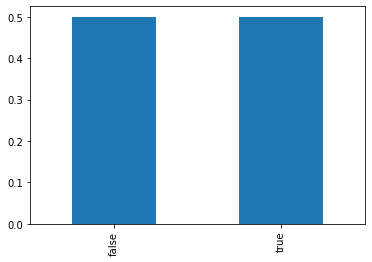

In [11]:
(df_oversampled['Ruling_Slug'].value_counts()/np.float(len(df_oversampled))).plot.bar()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


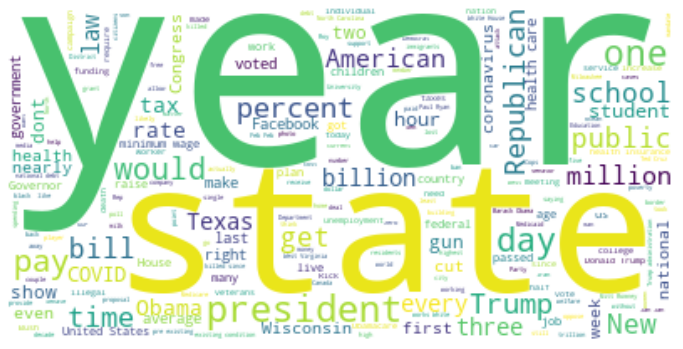

In [12]:
# Wordcloud beautification for True news

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words('english')
extendStopWords = ['Say','Says','said','people']
stopwords.extend(extendStopWords)

true_word_tokens = pd.Series(
    df[df['Ruling_Slug'] == 'true'].Statement.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=200, stopwords=stopwords, random_state=None, background_color='white').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

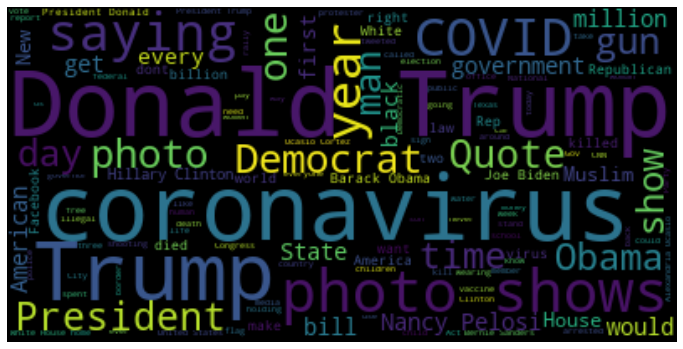

In [13]:
false_word_tokens = pd.Series(
    df[df['Ruling_Slug'] == 'false'].Statement.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=200, stopwords=stopwords, random_state=None, background_color='black').generate(false_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
labels = df_oversampled.Ruling_Slug

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0f6e31e10>,
      dtype=object)

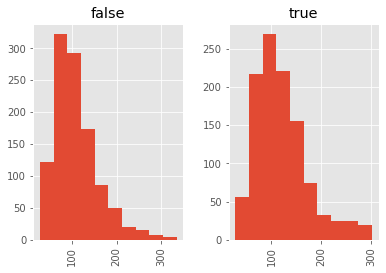

In [15]:
#  the number of characters present in each text by labels
df_oversampled['Statement'].str.len().hist(by=df_oversampled['Ruling_Slug'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0f6cba080>,
      dtype=object)

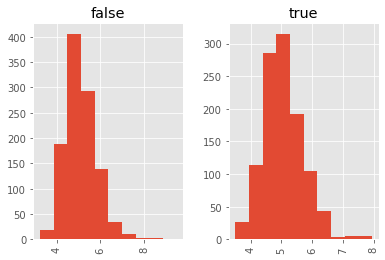

In [16]:
# Word level analysis of title
df_oversampled['Statement'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=df_oversampled['Ruling_Slug'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


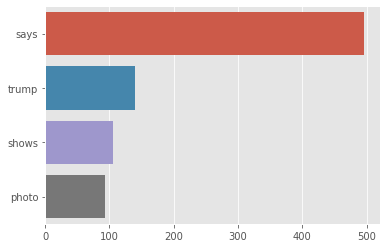

In [17]:
# Remove stopwords from title and text by label
import string
from collections import defaultdict, Counter
import seaborn as sns

false_news=df[df.Ruling_Slug=='false'].copy()
true_news=df[df.Ruling_Slug=='true'].copy()

# Corpus analysis for fake news statements

stop=set(stopwords)
false_news['Statement'] = false_news['Statement'].str.lower()
false_news['Statement'] = false_news.Statement.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = false_news['Statement'].str.split()
new=new.values.tolist()
corpus_fake=[word for i in new for word in i]

counter=Counter(corpus_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [18]:

# Ngram analysis function

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

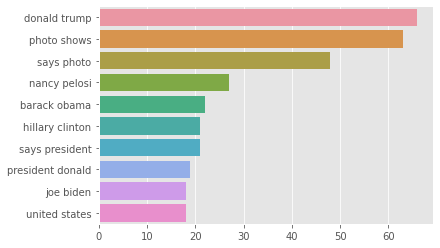

In [19]:
# Ngram analysis for fake news articles
from sklearn.feature_extraction.text import CountVectorizer
false_news['Statement'] = false_news['Statement'].str.lower()
false_news['Statement'] = false_news.Statement.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
false_news['Statement'] = false_news['Statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(false_news['Statement'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

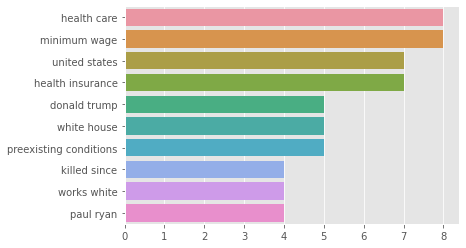

In [20]:
# Ngram analysis for true news articles
from sklearn.feature_extraction.text import CountVectorizer
true_news['Statement'] = true_news['Statement'].str.lower()
true_news['Statement'] = true_news.Statement.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
true_news['Statement'] = true_news['Statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(true_news['Statement'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)